## Question **1** Data Collection
For this homework, no dataset has been provided. Instead, you have to build your own. Your search engine will run on text documents. So, here we detail the procedure to follow for the data collection. We strongly suggest you work on different modules when implementing the required functions. For example, you may have a crawler.py module, a parser.py module, and a engine.py module: this is a good practice that improves readability in reporting and efficiency in deploying the code. Be careful; you are likely dealing with exceptions and other possible issues!

In [27]:
import requests
import os
import csv
from bs4 import BeautifulSoup
from concurrent.futures import ThreadPoolExecutor, as_completed
import pandas as pd
from collections import defaultdict
from tabulate import tabulate

### 1.1. Get the list of Michelin restaurants

You should begin by compiling a list of restaurants to include in your document corpus. Specifically, you will focus on web scraping the [Michelin Restaurants in Italy](https://guide.michelin.com/en/it/restaurants). Your task is to **collect the URL** associated with each restaurant in this list. The output of this step should be a `.txt` file where each line contains a single restaurant’s URL. By the end, you should have approximately 2,000 restaurants on your list. The number changes daily, so some groups might have different number of restaurants.

In [28]:
def restaurants_list_txt(base_url, output_path):
    restaurant_urls = []
    for page in range(1, 101):
      page_url = f"{base_url}/page/{page}" if page > 1 else base_url
      response = requests.get(page_url)

      if response.status_code == 200:
         # soup is an object of the BeautifulSoup class that contains the HTML content of the page
         soup = BeautifulSoup(response.content, 'html.parser')
         links = soup.find_all('a', href=True, class_='link')
         for link in links:
            href = link['href']
            if '/restaurant/' in href:
                full_url = "https://guide.michelin.com" + href
                restaurant_urls.append(full_url)
      else:
         print(f"Failed to retrieve page {page}")

    with open(output_path, 'w') as file:
        for url in restaurant_urls:
            file.write(url + '\n')

    print(f"Finded {len(restaurant_urls)} restaurant URLs")

restaurants_list_txt("https://guide.michelin.com/en/it/restaurants", "restaurants_list.txt")

Finded 1981 restaurant URLs


The `restaurants_list_txt` function automates the process of gathering restaurant URLs from the Michelin Guide website and saving them to a text file. It starts with a given `base_url` and navigates through up to 100 pages by dynamically constructing the URLs. For the first page, it uses the `base_url` as is, while for subsequent pages, it adds `/page/{page}` to handle pagination.

For each page, the function sends an HTTP GET request and parses the response using `BeautifulSoup` to identify links with the class `'link'`. It filters these links to include only those containing `/restaurant/` in their `href`, then appends the full URL (with the base domain included) to a list. If any page fails to load, indicated by a non-200 status code, it logs an error message.

After collecting all valid URLs, the function saves them into the specified output file (`restaurants_list.txt`), with each URL on a new line. It also prints the total number of URLs retrieved. This function streamlines the process of creating a list of restaurant pages, making it easy to use the URLs for tasks such as downloading detailed information or conducting further analysis.

### 1.2. Crawl Michelin restaurant pages

Once you have all the URLs on the list, you should:

1. Download the HTML corresponding to each of the collected URLs.
2. After collecting each page, immediately save its `HTML` in a file. This way, if your program stops for any reason, you will not lose the data collected up to the stopping point.
3. Organize the downloaded `HTML` pages into folders. Each folder will contain the `HTML` of the restaurants from page 1, page 2, ... of the Michelin restaurant list.

__Tip__: Due to the large number of pages to download, consider using methods that can help shorten the process. If you employed a particular process or approach, kindly describe it.

In [29]:
import time

def download_html_pages(urls, page_number, output_path):
    folder_name = f"page_{page_number}"
    folder_path = os.path.join(output_path, folder_name)
    os.makedirs(folder_path, exist_ok=True)

    for index, url in enumerate(urls):
        url = url.strip()
        try:
            response = requests.get(url)
            if response.status_code == 200:
                file_name = f"restaurant_{(page_number-1) * 20 + index + 1}.html"
                file_path = os.path.join(folder_path, file_name)
                with open(file_path, 'w', encoding='utf-8') as html_file:
                    html_file.write(response.text)
            else:
                print(f"Failed to download {url} (Status code: {response.status_code})")
        except Exception as e:
            print(f"Error downloading {url}: {e}")
        time.sleep(1)

def crawler(input_file_path, output_path, max_workers=5, num_urls_page=20):
    os.makedirs(output_path, exist_ok=True)

    with open(input_file_path, 'r') as file:
        restaurant_urls = file.readlines()

    url_chunks = [
        restaurant_urls[i:i + num_urls_page]
        for i in range(0, len(restaurant_urls), num_urls_page)
    ]

    # Use ThreadPoolExecutor to download pages for each page folder in parallel
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [
            executor.submit(download_html_pages, urls, page_number + 1, output_path)
            for page_number, urls in enumerate(url_chunks)
        ]
        for future in as_completed(futures):
            try:
                # Wait for the result to raise any exceptions that may have been set
                future.result()
            except Exception as e:
                print(f"Exception occurred: {e}")

    print("HTML download completed!")

crawler("restaurants_list.txt", "michelin_html_pages")


HTML download completed!


The `download_html_pages` function handles downloading HTML pages for a specific set of URLs and saving them in a designated folder. Each set of URLs corresponds to a unique folder, such as `page_1` or `page_2`. It ensures the folder exists using `os.makedirs`. For each URL in the set, the function sends an HTTP GET request via the `requests` library. If the response is successful (status code 200), the HTML content is saved to a file using a sequential naming convention based on the `page_number` and the URL's position in the group. The function gracefully manages errors, logging any issues encountered during the download process.

The `crawler` function coordinates the entire process of downloading HTML files. It starts by verifying the existence of the output directory. Next, it reads a list of restaurant URLs from the specified input file and divides them into chunks, each containing a specified number of URLs (defaulting to 20 per page). Each chunk is assigned its own folder. The function uses `ThreadPoolExecutor` to manage multiple threads, with each thread processing a chunk of URLs in parallel by calling the `download_html_pages_for_folder` function. Exceptions encountered by individual threads are logged to ensure the overall process continues smoothly. Once all tasks are completed, the function prints a summary message indicating the successful completion of the download process.

### How Threading is Used in the Crawler

Threading is implemented in the `crawler` function using the `ThreadPoolExecutor` to enable concurrent execution. Instead of processing each group of URLs one by one, the `ThreadPoolExecutor` distributes the workload across a configurable number of threads (`max_workers`, defaulting to 10). Each thread independently handles a specific set of URLs, downloading and saving the corresponding HTML files. The `executor.submit` method queues tasks to the executor, ensuring each thread processes a unique chunk, thus achieving parallelism. Using `as_completed`, the function monitors task progress in real-time, allowing exceptions within a thread to be handled without disrupting other threads. This multithreaded approach significantly improves performance by leveraging concurrent network requests and file operations, making it ideal for efficiently handling large datasets.

### 1.3 Parse downloaded pages

At this point, you should have all the HTML documents about the restaurant of interest, and you can start to extract specific information. The list of the information we desire for each restaurant and their format is as follows:

1. **Restaurant Name** (to save as `restaurantName`): string;
2. **Address** (to save as `address`): string;
3. **City** (to save as `city`): string;
4. **Postal Code** (to save as `postalCode`): string;
5. **Country** (to save as `country`): string;
6. **Price Range** (to save as `priceRange`): string;
7. **Cuisine Type** (to save as `cuisineType`): string;
8. **Description** (to save as `description`): string;
9. **Facilities and Services** (to save as `facilitiesServices`): list of strings;
10. **Accepted Credit Cards** (to save as `creditCards`): list of strings;
11. **Phone Number** (to save as `phoneNumber`): string;
12. **URL to the Restaurant Page** (to save as `website`): string.

This is the first few rows of the scraped dataset:

<div style="overflow-x:auto;">
<table>
<thead>
  <tr>
    <th>index</th>
    <th>restaurantName</th>
    <th>address</th>
    <th>city</th>
    <th>postalCode</th>
    <th>country</th>
    <th>priceRange</th>
    <th>cuisineType</th>
    <th>description</th>
    <th>facilitiesServices</th>
    <th>creditCards</th>
    <th>phoneNumber</th>
    <th>website</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>0</td>
    <td>Abbruzzino Oltre</td>
    <td>Piazza Salvo d'Acquisto 16</td>
    <td>Lamezia Terme</td>
    <td>88046</td>
    <td>Italy</td>
    <td>€€€€</td>
    <td>Contemporary, Mediterranean Cuisine</td>
    <td>This restaurant, the new home of young chef Luca Abbruzzino, occupies the first floor of a historic palazzo...</td>
    <td>['Air conditioning']</td>
    <td>['Amex', 'Mastercard', 'Visa']</td>
    <td>+39 0968 188 8038</td>
    <td>http://www.abbruzzinoltre.it</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Gallo Nero</td>
    <td>Via del Porrione 65/67</td>
    <td>Sienna</td>
    <td>53100</td>
    <td>Italy</td>
    <td>€€€</td>
    <td>Regional Cuisine, Contemporary</td>
    <td>Situated on the edge of the Leocorno contrada in Siena, Gallo Nero offers a traditional, rustic atmosphere...</td>
    <td>['Air conditioning', 'Terrace']</td>
    <td>[]</td>
    <td>+39 0577 284356</td>
    <td>https://www.ristorantegallonero.it/</td>
  </tr>
  <tr>
    <td>2</td>
    <td>La Locanda di Fabio e Vale</td>
    <td>via Brescia 1</td>
    <td>Offanengo</td>
    <td>26010</td>
    <td>Italy</td>
    <td>€€</td>
    <td>Modern Cuisine, Creative</td>
    <td>Young, informal and friendly owners Fabio and Vale bring a refreshing touch to the dining experience...</td>
    <td>['Air conditioning', 'Terrace']</td>
    <td>['Mastercard', 'Visa']</td>
    <td>+39 346 148 3963</td>
    <td>http://www.lalocandadifabioevale.it</td>
  </tr>
  <tr>
    <td>3</td>
    <td>Donevandro</td>
    <td>via Garibaldi 2</td>
    <td>Popoli</td>
    <td>65026</td>
    <td>Italy</td>
    <td>€€</td>
    <td>Contemporary, Seasonal Cuisine</td>
    <td>Up until a few years ago, the owner-chef at this contemporary establishment worked in several renowned kitchens...</td>
    <td>['Air conditioning']</td>
    <td>['Mastercard', 'Visa']</td>
    <td>+39 388 887 6858</td>
    <td>http://www.donevandroristorante.it</td>
  </tr>
  <tr>
    <td>4</td>
    <td>Masseria Moroseta</td>
    <td>Contrada Lamacavallo</td>
    <td>Ostuni</td>
    <td>72017</td>
    <td>Italy</td>
    <td>€€€€</td>
    <td>Mediterranean Cuisine, Modern Cuisine</td>
    <td>Chef Giorgia Eugenia Goggi offers a unique and refined interpretation of Apulian cuisine at Masseria Moroseta...</td>
    <td>['Car park', 'Terrace']</td>
    <td>['Amex', 'Mastercard', 'Visa']</td>
    <td>+39 376 079 8288</td>
    <td>https://www.masseriamoroseta.it</td>
  </tr>
</tbody>
</table>
</div>

For each restaurant, you create a `restaurant_i.tsv` file of this structure:

```
restaurantName \t address \t  ... \t url
```

If an information is missing, you just leave it as an empty string.

In [30]:
def parse_restaurant_html(file_path,index):
    with open(file_path, 'r', encoding='utf-8') as file:
        soup = BeautifulSoup(file, 'html.parser')

   # Restaurant Name
    restaurant_name = soup.find("h1",{"class": "data-sheet__title"}).get_text(strip=True) if soup.find("h1",{"class": "data-sheet__title"}) else "/"

    # Address, City, Postal Code, Country, Price Range, Cuisine Type
    divs = soup.find_all("div", {"class": "data-sheet__block--text"})
    divs_array = []
    for div in divs:
       text = div.get_text(strip=True)
       divs_array.append(text)

    if divs_array[0]:
       elements = divs_array[0].split(",")
       elements = [str(part) for part in elements]
       address = elements[0]
       country = elements[-1]
       postalCode = elements[-2]
       city = elements[-3]
    else:
       address, city, postalCode, country = "", "", "", ""

    cleaned_text = divs_array[1].replace('\n', ' ')
    elements = [part.strip() for part in cleaned_text.split('·')]
    price_range, cuisine_type = [elements[0],elements[1]] if elements  else ["", ""]

    # Description
    description = soup.find("div", {"class": "data-sheet__description"}).get_text(strip=True) if soup.find("div", {"class": "data-sheet__description"}) else ""


    # Facilities and Services
    div = soup.find("div", {"class": "col col-12 col-lg-6"}) if soup.find("div", {"class": "col col-12 col-lg-6"}) else ""
    if div:
        li_elements = div.find_all("li")
        li_texts = [li.get_text(strip=True) for li in li_elements]
        facilities_services = li_texts

    #Credit Cards
    div = soup.find("div", {"class": "list--card"})
    if div:
       img_elements = div.find_all("img", {"class": "lazy"})
    else:
       img_elements = []

    #Payment Providers
    payment_providers = []
    for img in img_elements:
        data_src = img.get('data-src')
        if data_src:
            provider = data_src.split('/')[-1].split('-')[0]
            payment_providers.append(provider.capitalize())
    credit_cards = payment_providers

    #Phone Number
    div = soup.find("div", {"class": "d-flex"})
    phone_number = div.find("span", {"class": "flex-fill"}).get_text(strip=True) if div.find("span", {"class": "flex-fill"}) else ""

    #Website
    div = soup.find("div", {"class": "collapse__block-item link-item"}) if soup.find("div", {"class": "collapse__block-item link-item"}) else ""
    website = div.find("a").get("href") if div.find("a")!=-1 else ""

    return {
        "index": index,
        "restaurantName": restaurant_name,
        "address": address,
        "city": city,
        "postalCode": postalCode,
        "country": country,
        "priceRange": price_range,
        "cuisineType": cuisine_type,
        "description": description,
        "facilitiesServices": facilities_services,
        "creditCards": credit_cards,
        "phoneNumber": phone_number,
        "website": website,
    }

def process_chunk(files_chunk, output_path, start_index):
    for i, file_path in enumerate(files_chunk):

        restaurant_data = parse_restaurant_html(file_path, start_index + i)

        tsv_file_name = f"restaurant_{start_index + i + 1}.tsv"
        tsv_file_path = os.path.join(output_path, tsv_file_name)
        with open(tsv_file_path, 'w', newline='', encoding='utf-8') as tsv_file:
            writer = csv.DictWriter(tsv_file, fieldnames=restaurant_data.keys(), delimiter='\t')
            writer.writeheader()
            writer.writerow(restaurant_data)

def parser(input_path, output_path, max_workers=5, chunk_size=100):
    os.makedirs(output_path, exist_ok=True)

    # Get all HTML files from the input directory
    all_files = []
    for root, dirs, files in os.walk(input_path):
        for file in files:
            if file.endswith(".html"):
                all_files.append(os.path.join(root, file))

    file_chunks = [all_files[i:i + chunk_size] for i in range(0, len(all_files), chunk_size)]

    # Use ThreadPoolExecutor to process each chunk in parallel
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [
            executor.submit(process_chunk, chunk, output_path, i * chunk_size)
            for i, chunk in enumerate(file_chunks)
        ]

        # Track progress and handle exceptions
        for future in as_completed(futures):
            try:
                # Wait for the result to raise any exceptions that may have been set
                future.result()
            except Exception as e:
                print(f"Exception occurred: {e}")

    print(f"Parsing and TSV file creation completed! Parsed {len(all_files)} files")

parser("michelin_html_pages", "michelin_tsv_files")

Parsing and TSV file creation completed! Parsed 1981 files


The function processes HTML files from a directory specified by `input_path`, converts their content into TSV files, and saves them to the `output_path`. It scans all subdirectories to gather HTML files, divides them into chunks of a specific size (`chunk_size`, defaulting to 100), and processes these chunks in parallel. Each HTML file is analyzed to extract relevant data (using a function like `process_chunk`), which is then transformed into a dictionary format and saved as a TSV file. The function ensures one TSV file per HTML file, with a sequential naming convention such as `restaurant_1.tsv`, `restaurant_2.tsv`. After all files are processed, it prints the total number of files parsed.

### How Threading is Used in the Parser

Threading is implemented with Python's `ThreadPoolExecutor` from the `concurrent.futures` module to enhance efficiency by processing files in parallel. The function splits the total list of files into chunks of `chunk_size` (default 100 files per chunk) and assigns each chunk to a thread for independent processing. A `ThreadPoolExecutor` is created with a specified number of threads (`max_workers`, defaulting to 10), and each thread executes the `process_chunk` function via `executor.submit`. The `as_completed` function monitors thread progress, ensuring that errors in individual threads do not disrupt the overall execution. This approach enables efficient parallel processing, allowing multiple HTML files to be parsed at the same time, while keeping tasks isolated to manage large datasets effectively.

Merge TSV in CSV:

In [31]:
def merge_tsv_to_csv(input_folder, output_file):
    all_data = pd.DataFrame()

    for file in os.listdir(input_folder):
        if file.endswith(".tsv"):
            file_path = os.path.join(input_folder, file)
            df = pd.read_csv(file_path, sep='\t',dtype={'postalCode': str})
            all_data = pd.concat([all_data, df], ignore_index=True)

    all_data.to_csv(output_file, index=False)
    print("Merge completed!")

merge_tsv_to_csv("michelin_tsv_files", "michelin_restaurants.csv")

Merge completed!


Create a DataSet from the CSV file

In [32]:
data = pd.read_csv('michelin_restaurants.csv',dtype={'postalCode': str})
data = data.sort_values(by='index', ascending=True)
data.head()

index                      restaurantName                    address  \
0         0                      O Me O Il Mare             Via Roma 45/47   
1093      1                      Alessandro Feo        via Angelo Lista 24   
1204      2                                Dama                 Via Mulino   
1315      3  Il Ristorante Alain Ducasse Napoli  Via Cristoforo Colombo 45   
1426      4                       Palazzo Utini      via Antonio Gramsci 6   

                         city postalCode country priceRange  \
0                    Gragnano      80054   Italy       €€€€   
1093   Marina di Casal Velino      84040   Italy         €€   
1204                Cervesina      27050   Italy        €€€   
1315                   Naples      80133   Italy       €€€€   
1426                   Noceto      43015   Italy       €€€€   

                               cuisineType  \
0     Italian Contemporary, Modern Cuisine   
1093                    Campanian, Seafood   
1204                        Modern Cuisine   
1315       Creative, Mediterranean Cuisine   
1426                Creative, Contemporary   

                                            description  \
0     Known around the world as the town of pasta, G...   
1093  In a beautiful stone-vaulted building (an old ...   
1204  Situated just a few kilometres from Voghera in...   
1315  Alain Ducasse, one of the great names in conte...   
1426  This historic building in the town centre has ...   

                                     facilitiesServices  \
0     ['Air conditioning', 'Interesting wine list', ...   
1093                                                 []   
1204            ['Garden or park', 'Wheelchair access']   
1315  ['Air conditioning', 'Great view', 'Interestin...   
1426  ['Air conditioning', 'Interesting wine list', ...   

                                            creditCards        phoneNumber  \
0          ['Amex', 'Dinersclub', 'Mastercard', 'Visa']   +39 081 620 0550   
1093  ['Amex', 'Dinersclub', 'Discover', 'Maestrocar...   +39 328 893 7083   
1204                     ['Amex', 'Mastercard', 'Visa']      +39 0383 3331   
1315  ['Amex', 'Dinersclub', 'Discover', 'Maestrocar...   +39 081 604 1580   
1426       ['Amex', 'Dinersclub', 'Mastercard', 'Visa']  +39 0521 152 1001   

                                                website  
0                                 http://omeoilmare.com  
1093            https://www.alessandrofeoristorante.it/  
1204                    https://www.hcsg.it/ristorante/  
1315  https://theromeocollection.com/en/romeo-napoli...  
1426                           https://palazzoutini.com

## Question 2

### 2.0 Preprocessing the Text


### 1: Tokenization
- Splits text into individual words (tokens).
- Removes punctuation and converts text to lowercase.

**Example:**  
*"Michelin-starred restaurant serves exquisite dishes in Paris!"*  
**Processed Tokens:**  
`["michelinstarred", "restaurant", "serves", "exquisite", "dishes", "paris"]`

---

### 2: Stopword Removal
- Removes common words like "and", "is", "the" that do not contribute meaning.  
**Before:**  
`["michelinstarred", "restaurant", "serves", "exquisite", "dishes", "paris"]`  
**After:**  
`["michelinstarred", "restaurant", "exquisite", "dishes", "paris"]`

---

### 3: Stemming
- Reduces words to their base forms.  
**Examples:**  
`"serving" → "serv"`  
`"dishes" → "dish"`

**Final Tokens:**  
`["michelinstar", "restaurant", "exquisit", "dish", "paris"]`

---

## Processed Columns
Preprocessing is applied to the following:
- `restaurant_name`
- `description`
- `city`
- `country`

---

## Example: Preprocessing in Action

**Raw Description:**  
*"Michelin-starred restaurant offering exquisite French cuisine in Paris."*  
**Processed Description:**  
`"michelinstar restaur offer exquisit french cuisin pari"`


In [33]:
import pandas as pd
import re
import math
import json
from collections import defaultdict
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Initialize NLP tools for preprocessing

stop_words = set(stopwords.words('english'))  # this collect the most Common stopwords in english

# Stemmer for reducing words to their base forms
stemmer = PorterStemmer()  

def preprocess_text(text):
    if not isinstance(text, str):
        return []
    text = re.sub(r"[^a-zA-Z0-9\s]", " ", text)  # this remove all special characters
    text = re.sub(r"\s+", " ", text).strip()  # this remove extra spaces
    tokens = text.lower().split()   ## convert text in lowercase and split into individual tokens -- words
    return [stemmer.stem(word) for word in tokens if word not in stop_words]   # now stem each word and exclude stopwords

## 2.1 Building the Vocabulary and Inverted Index

The vocabulary and inverted index are fundamental components for efficient text-based search. Here’s a breakdown of their creation:

---

### 1: Build Vocabulary
- Maps each unique word in the dataset to a unique integer (Term ID).
- **Input:** Preprocessed descriptions.
- **Output:** A dictionary where keys are words and values are Term IDs.

**Example Vocabulary:**  
| Word          | Term ID |
|---------------|---------|
| "dish"        | 0       |
| "restaurant"  | 1       |
| "paris"       | 2       |

### 2: Build Inverted Index

- Maps each Term ID to a list of Document IDs where the term appears.
- Input: Preprocessed descriptions and vocabulary.
- Output: A dictionary where keys are Term IDs and values are lists of Document IDs.


| Term ID       | Document ID |
|---------------|---------    |
| 0        | 	[1, 3, 5]           |
| 1  | [0, 2, 4]           |
| 2       |   [2]           |

In [34]:
def build_vocabulary(documents):
    # extract all documents, extract unique words, sort them, and assign each a unique integer ID
    return {word: idx for idx, word in enumerate(sorted(set(word for doc in documents for word in doc)))}

def build_inverted_index(documents, vocabulary):
    inverted_index = defaultdict(list)
     # Loop through each document and word to populate the inverted index
    for doc_id, doc in enumerate(documents):
        for word in doc:
            if word in vocabulary:   # Only include words from the vocabulary
                term_id = vocabulary[word] ## Map the word to its term ID
                if doc_id not in inverted_index[term_id]: 
                    inverted_index[term_id].append(doc_id)
    return inverted_index

# Load dataset
df = pd.read_csv('michelin_restaurants.csv')

# Preprocess restaurant descriptions
descriptions = [preprocess_text(desc) for desc in df['description']]

# Create vocabulary and inverted index
vocabulary = build_vocabulary(descriptions)  # Map words to unique IDs
inverted_index = build_inverted_index(descriptions, vocabulary)  # Map term IDs to document IDs

# Save vocabulary and inverted index for future use
vocabulary_path = 'vocabulary.csv'
inverted_index_path = 'inverted_index.json'

# Save vocabulary as CSV
pd.DataFrame(list(vocabulary.items()), columns=["Word", "Term ID"]).to_csv(vocabulary_path, index=False)

# Save inverted index as JSON
with open(inverted_index_path, 'w') as f:
    json.dump(inverted_index, f)

print(f"Vocabulary and inverted index created and saved to files.")


Vocabulary and inverted index created and saved to files.


## 2.1 Executing a Conjunctive Query

A conjunctive query retrieves documents (restaurants) where **all query words** are present in their descriptions. Below is a concise breakdown of how it works:

---

### **Function: `conjunctive_query`**
This function performs sush as :
1. **Preprocess the Query:**
   - Tokenizes, cleans, and stems the query text.
   - Converts query words into their corresponding Term IDs using the vocabulary.

2. **Find Matching Documents:**
   - Intersects the lists of Document IDs for all Term IDs in the query.
   - Ensures that only documents containing all query terms are returned.


### Example: Conjunctive Query Execution

### **Input Query**
*"Michelin-starred fine dining in Paris"*

---

### **Steps**

1. **Preprocess the Query**  
   - **Tokens:**  
     `["michelinstar", "fine", "dine", "pari"]`

2. **Convert Tokens to Term IDs**  
   - Using the vocabulary:  
     `["michelinstar" → 12, "fine" → 34, "dine" → 56, "pari" → 78]`  
   - **Term IDs:**  
     `[12, 34, 56, 78]`

3. **Retrieve Matching Documents**  
   - Using the inverted index, find documents containing all terms:  
     **Matching Document IDs:** `[0, 5, 9]`

4. **Output Results**  
   - Display restaurant names, addresses, descriptions, and websites for matching documents.

---

### **Results Table**

| Restaurant Name       | Address          | Description                                      | Website               |
|-----------------------|------------------|------------------------------------------------|-----------------------|
| Le Jules Verne        | Eiffel Tower     | A Michelin-starred restaurant in Paris.         | www.lejulesverne.com |
| L'Astrance            | Rue Beethoven    | Fine dining experience with exquisite cuisine.  | www.lastrance.com    |
| Epicure               | Rue Saint-Honoré | Luxurious dining at the heart of Paris.         | www.epicure.com      |

---

### **Number of Matching Restaurants**  
`3`


In [35]:
def conjunctive_query(query, vocabulary, inverted_index):
    query_tokens = preprocess_text(query)  # Preprocess the query terms
    term_ids = [vocabulary[word] for word in query_tokens if word in vocabulary]  # Map query words to term IDs

    if not term_ids:  # If no query words are in the vocabulary, return empty
        return []

    # Find documents containing all the terms (intersection of lists)
    matching_docs = set(inverted_index[term_ids[0]])  # Start with the first term's document list
    for term_id in term_ids[1:]:
        matching_docs &= set(inverted_index.get(term_id, []))  # Intersect with subsequent term's document lists

    return list(matching_docs)  # Return the matching document IDs


# Input query from user
query = input("Enter your query: ")

# Execute conjunctive query
matching_docs = conjunctive_query(query, vocabulary, inverted_index)

# Create a results table
table = []
for idx in matching_docs:
    row = df.iloc[idx]
    table.append({
        "restaurantName": row['restaurantName'],  # Restaurant name
        "address": row['address'],               # Address
        "description": row['description'],       # Description
        "website": row['website']                # Website URL
    })

# Display the results table in the desired format
display(pd.DataFrame(table))
print(f"Number of matching restaurants: {len(matching_docs)}")

# To check if it works, you can input the phrase down here, the output should be only the row for the restaurant "Osteria Numero 2":

# A beautiful farmhouse not far from the town, with a friendly, welcoming and colourful feel. Here, the menu features Italian dishes alongside a few local specialities,
# such as agnoli pasta in broth (also available as an antipasto in a “sorbir” wine broth). Special mention goes to the superb selection of beers chosen by owner Moreno,
# which ranges from local craft beers to labels from across the globe – there’s even a beer-themed dessert, the Birramisù. Excellent value for money and highly popular, so booking ahead is recommended. 

restaurantName           address  \
0  Osteria Numero 2  via Ghisiolo 2/a   

                                         description  \
0  A beautiful farmhouse not far from the town, w...   

                          website  
0  https://www.osterianumero2.it/

Number of matching restaurants: 1


### **2.2 Conjunctive Query & Ranking Score**

For the second Search Engine, given a query, we want to get the *top-k* (in this case, we chose $k=5$) documents related to the query and a **similarity** measure. In particular, we chose to perform the following procedure:

1. We built a dictionary containing all the words found in the `description` column of each document (or reused a previously built vocabulary). Using this vocabulary, we built the **TfIdf inverted index** of the words. The TfIdf inverted index is a dictionary of the form:

    ```
    {
    term_id_1:[(document_1, tfIdf_{term,document1}), (document_2, tfIdf_{term,document2}), (document_4, tfIdf_{term,document4})],
    term_id_2:[(document_1, tfIdf_{term,document1}), (document_3, tfIdf_{term,document3}), (document_5, tfIdf_{term,document5}), (document_6, tfIdf_{term,document6})],
    ...}
    ```

    where `document_i` is the *id* of a document that contains a specific word, the `term_id_i` is the *id* of a specific word in the vocabulary, and the `TfIdf` is the Term Frequency-Inverse Document Frequency value of the `term_id_i` within `document_i`. The Term Frequency-Inverse Document Frequency is given by:

    \begin{equation}
    \text{TfIdf}(t,d) = \text{Tf}(t,d) \times \text{Idf}(t) =  \frac{freq(t,d)}{len(d)} \times \log \left(\frac{N}{1+df}\right),
    \end{equation}

    where $\text{Tf}(t,d)$ is the (normalized) frequency of times the term $t$ appears in document $d$, and $\text{Idf}(t)$ is the **inverse document frequency** of term $t$, where $df$ is the number of documents that include term $t$ and $N$ is the total number of documents. The purpose of the Idf is to give higher weight to terms that are rare across the entire corpus of text and lower weight to terms that are common.

    The TfIdf index gives a mapping from every word in the vocabulary to all the documents that contain it and a measurement of **how important** that word is within each document relative to its importance across all documents. 

2. Once we built (and saved) the vocabulary and TfIdf inverted index, we took a **query** as input. As a first step, we preprocess the query and then search for all the documents that contain **all** of the words/tokens in the query. To perform this search, we take advantage of the TfIdf inverted index since we only have to take the intersection of the lists of the terms contained in the query (the lists of the first elements of the tuple).



#### **2.2.1 Inverted Index**

As in the first Search Engine we built, the TfIdf inverted index is a fundamental tool for the Search Engine. This is why the index is computed *before* making any query and saved into memory. This allows it to be loaded when needed instead of being recalculated every time. To achieve this, the index is incorporated as a class **attribute**, so it is loaded into memory each time the `TopKSearchEngine` class is initialized.

As an exercise, we can observe the first 5 elements of the TfIdf inverted index value for the "data" term as follows:

```python
term_id = vocabulary["data"]
print(tfidf_inverted_index[term_id][:5])


In [36]:
def compute_tf(document):
    tf = defaultdict(int) #creating a dictionary for all the words in each document
    for word in document:
        tf[word] += 1 #increasing the value by one every time that the word appears in the document
    return {word: count / len(document) for word, count in tf.items()}  #normalization by document length

def compute_idf(documents, vocabulary):
    num_docs = len(documents)  
    doc_freq = defaultdict(int) #creation of a ditcionary with all the words across all documents
    for doc in documents:
        unique_words = set(doc)  #consider only unique words in each document to avoid repetitions for a word
        for word in unique_words:
            if word in vocabulary:
                doc_freq[word] += 1 #increasing the count if the word is in a document
    #returning the value of the idf score 
    return {word: math.log((num_docs + 1) / (doc_freq[word] + 1)) + 1 for word in vocabulary} 

def compute_tfidf(document, idf):
    tf = compute_tf(document) #applying the tf function for each document
    return {word: tf[word] * idf[word] for word in document if word in idf} #returning the value of the tf-idf score for each word in every document

# Calculate IDF for all words in the vocabulary
idf = compute_idf(descriptions, vocabulary)

# Calculate TF-IDF scores for all documents
tfidf = [compute_tfidf(doc, idf) for doc in descriptions]

# Build updated inverted index with TF-IDF scores
tfidf_inverted_index = defaultdict(list) #creating the dictionary
for doc_id, doc_tfidf in enumerate(tfidf): #for cycle on every id and score for every word in every document
    for word, score in doc_tfidf.items(): #for cycle on every word and its tf-idf score
        term_id = vocabulary[word] #setting the word id as a key
        tfidf_inverted_index[term_id].append((doc_id, score))  # Store document ID and TF-IDF score

# Save updated inverted index
tfidf_inverted_index_path = "inverted_index.json" 
with open(tfidf_inverted_index_path, 'w') as f: #opening the file to apply the json.dump function
    json.dump(tfidf_inverted_index, f)

print("TF-IDF scores computed and updated inverted index saved.")


TF-IDF scores computed and updated inverted index saved.


 Once we got all the relevant documents, we decided to sort them by their **Cosine Similarity** with respect to the query. The Cosine Similarity is a vector similarity measure that measures how similar two vectors $\vec{A}$ and $\vec{B}$ are by taking the angle $\theta$ between them. It is given by:

\begin{equation}
\text{sim}\left(\vec{A}, \vec{B}\right) = \cos(\theta) = \frac{\vec{A}\cdot\vec{B}}{|\vec{A}||\vec{B}|}.
\tag{2}
\end{equation}

In the context of NLP, we can represent documents as vectors where each vector value is the tfIdf representation of a term within the document. Therefore, we can obtain the similarity between documents by taking the **cosine similarity** of their tfIdf representations. In this case, we obtained the cosine similarity between the query and all the obtained documents. 
    
Once we had a similarity value for all the relevant documents, we **sorted** them in descending order with respect to the similarity with the query. To maintain the top-$k$ documents efficiently, we used a **max-heap** data structure.


In [37]:
def cosine_similarity(vec1, vec2):
    common_words = set(vec1.keys()) & set(vec2.keys())  # Find common words(ids seen as keys in the dictionary) between the query and the document
    numerator = sum(vec1[word] * vec2[word] for word in common_words)  # Dot product between the two vectors of tf-idf scores of the two phrases
    norm_vec1 = math.sqrt(sum(val ** 2 for val in vec1.values()))  # Computing the norm of the first vector
    norm_vec2 = math.sqrt(sum(val ** 2 for val in vec2.values()))  #Computing the norm of the second vector
    return numerator / (norm_vec1 * norm_vec2) if norm_vec1 and norm_vec2 else 0  # In case one of the vectors are 0(common words = 0), it returns 0

def ranked_query(query, k=5):

    query_tokens = preprocess_text(query)  # Preprocess the query terms
    query_tfidf = compute_tfidf(query_tokens, idf)  # Compute TF-IDF scores for the query

    scores = []
    for doc_id, doc_tfidf in enumerate(tfidf):
        similarity = cosine_similarity(query_tfidf, doc_tfidf)  # Compute similarity between the query and the document
        scores.append((doc_id, similarity))  # Store document ID and its similarity score with the query

    # Sort by similarity score and return top-k results
    scores.sort(key=lambda x: x[1], reverse=True)
    return scores[:k]

# Input query from user
query = input("Enter your query: ")

# Execute ranked query
top_k_results = ranked_query(query, k=5)

# Display results in a table
results_table = [
    {
        "Restaurant Name": df.iloc[doc_id]["restaurantName"],
        "Address": df.iloc[doc_id]["address"],
        "Description": df.iloc[doc_id]["description"],
        "Website": df.iloc[doc_id]["website"],
        "Similarity Score": f"{score:.4f}"
    }
    for doc_id, score in top_k_results
]

display(pd.DataFrame(results_table))  # Print the results table

# To check if it works, you can input the phrase down here, you should have as output "Osteria Numero 2" in first row with a 1.0000 score:

#  A beautiful farmhouse not far from the town, with a friendly, welcoming and colourful feel. Here, the menu features Italian dishes alongside a few local specialities, 
#  such as agnoli pasta in broth (also available as an antipasto in a “sorbir” wine broth). Special mention goes to the superb selection of beers chosen by owner Moreno, which ranges 
# from local craft beers to labels from across the globe – there’s even a beer-themed dessert, the Birramisù. Excellent value for money and highly popular, so booking ahead is recommended. 


Restaurant Name                    Address  \
0     Osteria Numero 2           via Ghisiolo 2/a   
1               Mogano  via del Praticello Alto 7   
2  Osteria Al GiGianca            via Broseta 113   
3      Le Due Lanterne        piazza Garibaldi 52   
4        Rosso di Sera         via Pietro Nenni 2   

                                         Description  \
0  A beautiful farmhouse not far from the town, w...   
1  Aiming to promote craft beers as a worthy pair...   
2  Although the out - of - town location is a sli...   
3  Situated in the town centre, this typical fami...   
4  Situated closed to the motorway exit, this res...   

                                   Website Similarity Score  
0           https://www.osterianumero2.it/           1.0000  
1           http://www.moganorestaurant.it           0.2197  
2              https://www.algigianca.com/           0.2136  
3  https://www.ristoranteleduelanterne.it/           0.1903  
4       https://www.osteriarossodisera.it/           0.1875

## Question 3. Define a New Score!
Now, we will define a custom ranking metric to prioritize restaurants based on user queries.

Steps:
* User Query: The user provides a text query. We’ll retrieve relevant documents using the search engine built in Step 2.1.
* New Ranking Metric: After retrieving relevant documents, we’ll rank them using a new custom score. Instead of limiting the scoring to only the description field, we can include other attributes like priceRange, facilitiesServices, and cuisineType.
* You will use a heap data structure (e.g., Python’s heapq library) to maintain the top-k restaurants.

#### New Scoring Function:  
Define a scoring function that takes into account various attributes:
* Description Match: Give weight based on the query similarity to the description (using TF-IDF scores).
* Cuisine Match: Increase the score for matching cuisine types.
Facilities and Services: Give more points for matching facilities/services (e.g., “Terrace,” “Air conditioning”).
* Price Range: Higher scores could be given to more affordable options based on the user’s choice.

### Output:
The output should include:
* restaurantName
* address
* description
* website
* The new similarity score based on the custom metric.  

Are the results you obtain better than with the previous scoring function? Explain and compare results.

## 3. **Define a New Scoring System!**

Can we do better? In the last implementation of our Search Engine, we sorted results by the **cosine similarity** of the TF-IDF representation of their `description` field with respect to the query. However, this approach does not account for the following considerations:

1. A restaurant can be **more relevant** to a query if it matches the query across multiple fields. For example:
    - If we search for the query *"pizza"* and it appears not only in the `description` but also in the `cuisineType` or `facilitiesServices`, these fields should contribute to the ranking score. Matching across multiple fields provides a broader understanding of relevance.

2. Users often prioritize restaurants that meet **additional preferences** such as:
    - **Facilities:** For example, a user searching for "wheelchair access" should find restaurants where this facility is explicitly listed.
    - **Price Compatibility:** Users may prefer restaurants that fit within their desired price range.
    - **Cuisine Type:** A user searching for "Italian" should find restaurants where this cuisine is explicitly provided.

To address these points, we propose a **weighted** scoring system that considers the following fields: `description`, `cuisineType`, `facilitiesServices`, and `priceRange`.

---

### **3.1 Custom Weighted Scoring Formula**

Our new scoring metric combines the cosine similarity of the query with multiple fields of the dataset (`description`, `cuisineType`, `facilitiesServices`) and considers the price compatibility. The formula is defined as:

\begin{equation}
\text{Score} = w_{\text{desc}} \cdot \text{CS}_{\text{desc}} + w_{\text{cuis}} \cdot \text{CS}_{\text{cuis}} + w_{\text{facil}} \cdot \text{CS}_{\text{facil}} + w_{\text{price}} \cdot \text{Sim}_{\text{price}}
\tag{1}
\end{equation}

---

### **3.2 Key Components**

\begin{equation}
\text{similarity}(\vec{d}, \vec{q}) = \frac{w_{\text{context}}}{3} \cdot \left[\text{cs}_{\text{description}}(\vec{d}, \vec{q}) + \text{cs}_{\text{cuis}}(\vec{d}, \vec{q}) + \text{cs}_{\text{facil}}(\vec{d}, \vec{q})\right] + \frac{w_{\text{price}}}{1} \cdot \text{Sim}_{\text{price}}
\tag{2}
\end{equation}

Where:
- **Cosine similarities:**
  \begin{equation}
  \text{CS}_{\text{desc}}, \text{CS}_{\text{cuis}}, \text{CS}_{\text{facil}}
  \tag{3}
  \end{equation}
  These represent the cosine similarities for `description`, `cuisineType`, and `facilitiesServices`, respectively.

- **Price compatibility:**
  \begin{equation}
  \text{Sim}_{\text{price}}
  \tag{4}
  \end{equation}
  It compares if the price of the restaurant is inside the boundary of the maximum price that the user is preventing to spend.

- **Weights:**
  \begin{equation}
  w_{\text{desc}}, w_{\text{cuis}}, w_{\text{facil}}, w_{\text{price}}
  \tag{5}
  \end{equation}
  These are the weights assigned to each factor, controlling their relative importance in the overall score.

---

### **3.3 Key Components**

#### **Cosine Similarity for Text Fields**

Cosine similarity is used to compute the alignment between the TF-IDF representation of the query and each field. It is defined as:

\begin{equation}
\text{CS}(\vec{A}, \vec{B}) = \frac{\vec{A} \cdot \vec{B}}{\|\vec{A}\| \cdot \|\vec{B}\|}
\tag{6}
\end{equation}

This ensures that fields with higher overlap with the query receive higher scores.

#### **Price Compatibility**

For the price similarity component:

\begin{equation}
\text{Sim}_{\text{price}}
\tag{7}
\end{equation}

We assign a score equal to the weight connected to the price if the price of the restaurant is not greater than the maximum price the user intend to spend.

---

### **3.4 Implementation**

We implemented this scoring system in Python using the following key functions:


In [ ]:
import numpy as np
from collections import defaultdict
import math
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from heapq import nlargest
import re


# Initialize NLP tools
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
# We decided to lemmatize the words in exercise 3 to try to catch a more precise match between our queries and our documents 

def preprocess_text(text):
    #applying the preprocess
    if not isinstance(text, str):
        return []
    text = re.sub(r"[^a-zA-Z0-9\s]", " ", text)  # Remove special characters
    text = re.sub(r"\s+", " ", text).strip()  # Remove extra spaces
    tokens = text.lower().split() #lowering and splitting all the words
    #stemming and then lemmatizing the words already preprocessed by all the removals descripted up above
    return [lemmatizer.lemmatize(stemmer.stem(word)) for word in tokens if word not in stop_words]

def build_vocabulary(documents):
    #creating a vocabulary just as did before for exercise 2.2
    return {word: idx for idx, word in enumerate(sorted(set(word for doc in documents for word in doc)))}

def optimized_get_idf(documents, vocabulary):
    doc_freq = defaultdict(int)
    for doc in documents:
        unique_words = set(doc) #applying set function to avoid repetition of the same word in the document
        for word in unique_words:
            if word in vocabulary:
                doc_freq[word] += 1 #increasing by one if the word is present in a document inside the vocabulary
    num_docs = len(documents)
    #in the end, creating the value for every key(word), with its idf score
    return {word: math.log((num_docs + 1) / (doc_freq[word] + 1)) + 1 for word in vocabulary}

def compute_tfidf(document, idf):
    tf = defaultdict(int) #calculating tf value for every word in a document
    for word in document:
        tf[word] += 1 #increase by one every time a word is in a document
    #returning the tf-idf for every word in every document
    return {word: (tf[word] / len(document)) * idf[word] for word in document if word in idf}

def cosine_similarity(vec1, vec2):
    #just as done in exercise 2.2, we calculate the cosine similarity between query and document strings
    common_words = set(vec1.keys()) & set(vec2.keys())
    numerator = sum(vec1[word] * vec2[word] for word in common_words)
    norm_vec1 = math.sqrt(sum(val ** 2 for val in vec1.values()))
    norm_vec2 = math.sqrt(sum(val ** 2 for val in vec2.values()))
    return numerator / (norm_vec1 * norm_vec2) if norm_vec1 and norm_vec2 else 0 #returning 0 if the two documents have no words in common

def compute_custom_score(tfidf_query_desc, tfidf_desc, tfidf_query_cuis, tfidf_cuis, tfidf_query_facil, tfidf_facil, max_price, doc_price, weights):
    w_desc, w_cuis, w_facil, w_price = weights #assigning the weights for each category

    # Cosine similarity for description
    sim_desc = cosine_similarity(tfidf_query_desc, tfidf_desc) * w_desc

    # Cosine similarity for cuisine type
    matching_cuis = cosine_similarity(tfidf_query_cuis, tfidf_cuis)* w_cuis

    # Cosine similarity for facilities and services
    matching_facil =  cosine_similarity(tfidf_query_facil, tfidf_facil) * w_facil

    # Price similarity
    # if the amount of money that the user wants to spend is under the price of the restaurant, it returns 0
    sim_price = w_price if doc_price <= max_price else 0

    # Total score
    return sim_desc + matching_cuis + matching_facil + sim_price

def get_top_k(query, cuis, facil, max_price, descriptions, prices, idf_desc, tfidf_desc, idf_cuis, tfidf_cuis, idf_facil, tfidf_facil, k=5, weights=(0.4, 0.2, 0.2, 0.2)):
    # Preprocess the queries for descriptions, cuisnetypes and facilities
    query_tokens = preprocess_text(query)
    cuis_tokens = preprocess_text(cuis)
    facil_tokens = preprocess_text(facil)

    # Compute query TF-IDF for descriptions, cuisinetype and facilities
    tfidf_query_desc = compute_tfidf(query_tokens, idf_desc)
    tfidf_query_cuis = compute_tfidf(cuis_tokens, idf_cuis)
    tfidf_query_facil = compute_tfidf(facil_tokens, idf_facil)

    scores = [] #empty list that will be filled up with tuples of index of the documents and its score, calculated as cosine similarity with the queries
    for idx in range(len(descriptions)):
        # Applying our function for the creation of the custom score
        score = compute_custom_score(
            tfidf_query_desc,
            tfidf_desc[idx],
            tfidf_query_cuis,
            tfidf_cuis[idx],
            tfidf_query_facil,
            tfidf_facil[idx],
            max_price,
            prices[idx],
            weights
        )
        scores.append((idx, score))

    # Get top-k results using a heap, based on the custom metric created by the function compute_custom_score
    return nlargest(k, scores, key=lambda x: x[1])

# Example Usage
if __name__ == "__main__":
    # Load dataset
    df = pd.read_csv("michelin_restaurants.csv")
    descriptions = [preprocess_text(desc) for desc in df['description']]
    cuisines = [preprocess_text(cuisine) for cuisine in df['cuisineType']]
    facilities = [preprocess_text(facility) for facility in df['facilitiesServices']]
    prices = [len(price) for price in df['priceRange']]  # Convert € symbols to numeric scale

    # Build vocabularies and IDF for every category in the score(except price)
    vocabulary_desc = build_vocabulary(descriptions)
    idf_desc = optimized_get_idf(descriptions, vocabulary_desc)

    vocabulary_cuis = build_vocabulary(cuisines)
    idf_cuis = optimized_get_idf(cuisines, vocabulary_cuis)

    vocabulary_facil = build_vocabulary(facilities)
    idf_facil = optimized_get_idf(facilities, vocabulary_facil)

    # Compute TF-IDF for documents, cuisines types and facilities
    tfidf_desc = [compute_tfidf(doc, idf_desc) for doc in descriptions]
    tfidf_cuis = [compute_tfidf(cuis, idf_cuis) for cuis in cuisines]
    tfidf_facil = [compute_tfidf(facil, idf_facil) for facil in facilities]

    # User inputs
    query = input("Enter your query for the description: ")
    cuis = input("Enter the cuisine types: ")
    facil = input("Enter the facilities: ")
    max_price = len(input("Enter the maximum price (€, €€, etc.): ").strip())  # Convert € symbols to numeric

    # Get top-k results
    top_k_results = get_top_k(query, cuis, facil, max_price, descriptions, prices, idf_desc, tfidf_desc, idf_cuis, tfidf_cuis, idf_facil, tfidf_facil, k=5)

    # Display results
    results_table = [
        {
            "Restaurant Name": df.iloc[idx]["restaurantName"],
            "Address": df.iloc[idx]["address"],
            "Description": df.iloc[idx]["description"],
            "Website": df.iloc[idx]["website"],
            "Score": f"{score:.4f}"
        }
        for idx, score in top_k_results
    ]

    display(pd.DataFrame(results_table))

# To check if it works, you can input the phrases down here, you should have as output "Osteria Numero 2" in first row with a 1.0000 score:
# For the description:
# A beautiful farmhouse not far from the town, with a friendly, welcoming and colourful feel. Here, the menu features Italian dishes alongside a few local specialities,
# such as agnoli pasta in broth (also available as an antipasto in a “sorbir” wine broth). Special mention goes to the superb selection of beers chosen by owner Moreno,
# which ranges from local craft beers to labels from across the globe – there’s even a beer-themed dessert, the Birramisù. Excellent value for money and highly popular, so booking ahead is recommended. 
# For the cuisine type input:
# Italian, Classic Cuisine
# For the facilities input:
# Air conditioning, Car park, Garden or park, Restaurant offering vegetarian menus, Terrace, Wheelchair access
# For the price input:
# €(or even greater)

Restaurant Name                  Address  \
0            Osteria Numero 2         via Ghisiolo 2/a   
1        Remo Villa Cariolato  strada di Bertesina 313   
2                  La Passion       via San Nicolò 5/b   
3  Vert Osteria Contemporanea         Località Bogonza   
4                   Aubergine          via Ghislandi 5   

                                         Description  \
0  A beautiful farmhouse not far from the town, w...   
1  Long recommended by the Michelin Guide, the hi...   
2  A small, cosy, completely wood - panelled stub...   
3  Housed in a rustic building on the green slope...   
4  Situated in a town famous for its thermal bath...   

                               Website   Score  
0       https://www.osterianumero2.it/  1.0000  
1    https://www.removillacariolato.it  0.6205  
2         https://www.lapassion.it/it/  0.5754  
3              https://vertosteria.it/  0.5428  
4  https://www.ristoranteaubergine.it/  0.5233

# Question 4 :  Visualizing the Most Relevant Restaurants

Maps can provide users with an intuitive way to see where restaurants are located. This is particularly useful for identifying regions in Italy with more dining options.

In [42]:
# Importing the dataframe
import pandas as pd
df = pd.read_csv('michelin_restaurants.csv', sep=',')
df

index        restaurantName                      address  \
0         0        O Me O Il Mare               Via Roma 45/47   
1         9                 20Tre     via David Chiossone 20 r   
2        99     Osteria Arbustico    via Francesco Gregorio 40   
3       999     Osteria del Borro            località Borro 52   
4      1000             Capriccio        via Filippo Turati 81   
...     ...                   ...                          ...   
1976    994        Osteria Altran          Località Cortona 19   
1977    995          Piccolo Lord  corso San Maurizio 69 bis/g   
1978    996                Silene           Località Pescina 9   
1979    997      Villa Fiordaliso         corso Zanardelli 150   
1980    998  Osteria Antico Brolo                via Carere 10   

                        city  postalCode country priceRange  \
0                   Gragnano       80054   Italy       €€€€   
1                      Genoa       16123   Italy         €€   
2                    Paestum       84047   Italy        €€€   
3      San Giustino Valdarno       52024   Italy        €€€   
4                    Augusta       96011   Italy         €€   
...                      ...         ...     ...        ...   
1976                    Ruda       33050   Italy        €€€   
1977                   Turin       10124   Italy         €€   
1978                Seggiano       58038   Italy        €€€   
1979         Gardone Riviera       25083   Italy       €€€€   
1980         Gardone Riviera       25083   Italy         €€   

                                  cuisineType  \
0        Italian Contemporary, Modern Cuisine   
1               Farm to table, Modern Cuisine   
2                   Modern Cuisine, Campanian   
3                        Tuscan, Contemporary   
4                                Contemporary   
...                                       ...   
1976                  Italian, Modern Cuisine   
1977  Mediterranean Cuisine, Seasonal Cuisine   
1978                   Tuscan, Modern Cuisine   
1979                     Italian Contemporary   
1980          Country cooking, Modern Cuisine   

                                            description  \
0     Known around the world as the town of pasta, G...   
1     Run by three partners, this contemporary-style...   
2     Housed within the Royal Paestum hotel, this el...   
3     Decorated in soft colours, the elegant gourmet...   
4     Young chef Graziano Accolla has returned to hi...   
...                                                 ...   
1976  A small gourmet restaurant surrounded by the v...   
1977  Professional service in a welcoming, modern re...   
1978  This authentic family restaurant situated in a...   
1979  Villa Fiordaliso is one of the beautiful early...   
1980  Situated in the upper part of the town near th...   

                                     facilitiesServices  \
0     ['Air conditioning', 'Interesting wine list', ...   
1                                  ['Air conditioning']   
2     ['Air conditioning', 'Car park', 'Garden or pa...   
3     ['Air conditioning', 'Car park', 'Garden or pa...   
4                       ['Air conditioning', 'Terrace']   
...                                                 ...   
1976  ['Air conditioning', 'Car park', 'Interesting ...   
1977                               ['Air conditioning']   
1978          ['Car park', 'Garden or park', 'Terrace']   
1979  ['Car park', 'Garden or park', 'Great view', '...   
1980                                        ['Terrace']   

                                            creditCards       phoneNumber  \
0          ['Amex', 'Dinersclub', 'Mastercard', 'Visa']  +39 081 620 0550   
1          ['Amex', 'Dinersclub', 'Mastercard', 'Visa']  +39 010 247 6191   
2     ['Amex', 'Dinersclub', 'Maestrocard', 'Masterc...   +39 0828 851525   
3                        ['Amex', 'Mastercard', 'Visa']  +39 055 977 2333   
4         ['Amex', 'Maestrocard', 'Mastercard', 'Visa']   +39 09

In [43]:
# Converting the postalCode values into integers in order to use them to detect the regions and 
# the coordinates 
import pandas as pd
import numpy as np

df['postalCode'] = df['postalCode'].apply(lambda x: int(x) if pd.notnull(x) else np.nan)

# Convert column to integer type, handling NaNs

df['postalCode'] = df['postalCode'].astype('Int64') 

To collect information regarding the cities, regions, and geographic coordinates, we employed a Google API tool, implemented in Python using the `Geocode` and `reverse geocode` libraries. 
This approach allowed us to efficiently retrieve and process geographic data, enabling us to convert addresses into latitude and longitude and vice versa.
To maximize the accuracy of the location data we designed our inputs to include the `address`,`city`,`postal code` and `country`, ensuring precise detection of coordinates.
Additionally, we conducted multiple tests using different combinations of inputs, firstly by implementing only the `city`,`postal code` and `country` and later using just `postal code`and `country`.\
Instead to retrieve information regarding the region we just implemented the `coordinates`. 
Despite these efforts, we encountered some errors related to the spelling of certain region names. To address these inaccuracies, we implemented systematic correction procedures, ensuring that all data was thoroughly verified and rectified.

In [44]:
# installing and importing the necessary packages. 
!pip install reverse-geocode
!pip install geopy
from geopy.geocoders import Nominatim
import reverse_geocode

In [45]:
# Correcting the name of the cities in order to be more comprehensible for the geocode package
df['city'] = df['city'].str.replace('.',' ')
df['city'] = df['city'].str.replace('_',' ')
df['city']

0                     Gragnano
1                        Genoa
2                      Paestum
3        San Giustino Valdarno
4                      Augusta
                 ...          
1976                      Ruda
1977                     Turin
1978                  Seggiano
1979           Gardone Riviera
1980           Gardone Riviera
Name: city, Length: 1981, dtype: object

In [46]:
from geopy.extra.rate_limiter import RateLimiter
from geopy.geocoders import Nominatim

# Defining a function capable of detecting the coordinates foe each restaurant
def get_coordinates(row):
    geolocator = Nominatim(user_agent='restaurant', timeout=10) 
    geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
    
    # full address
    full_address = f"{row['address']}, {row['city']}, {row['postalCode']}, Italy"
    location = geocode(full_address)
    if location:
        return location.latitude, location.longitude

    # city and postalCode only
    partial_address = f"{row['city']}, {row['postalCode']}, Italy"
    location = geocode(partial_address)
    if location:
        return location.latitude, location.longitude

    # only postalcode
    minimal_address = f"{row['postalCode']}, Italy"
    location = geocode(minimal_address)
    if location:
        return location.latitude, location.longitude

    return (None, None)

# Apply the function to the dataframe
df['coordinates'] = df.apply(get_coordinates, axis=1)

# Count remaining missing values to verify how many present null values
missing_count = df['coordinates'].isnull().sum()
print(f"Remaining unlocated coordinates: {missing_count}")


Remaining unlocated coordinates: 0


The function works correctly, providing all the information needed. 
No missing values are present

In [47]:
# separating the coordinates values in latitude and longitude and storing these new columns in the dataframe
df['latitude'] = df['coordinates'].apply(lambda x: x[0] if x else None)
df['longitude'] = df['coordinates'].apply(lambda x: x[1] if x else None)

In [48]:
# Displaying rows with missing coordinates 
missing_coordinates = df[(df['latitude'].isnull()) | (df['longitude'].isnull())]
print("Rows with missing coordinates:")
print(missing_coordinates)

Rows with missing coordinates:
Empty DataFrame
Columns: [index, restaurantName, address, city, postalCode, country, priceRange, cuisineType, description, facilitiesServices, creditCards, phoneNumber, website, coordinates, latitude, longitude]
Index: []


In [49]:
# Filter rows where 'coordinates' is None
df_none_coordinates = df[df['coordinates'].isnull()]

In [50]:
# Defining a function that can detect the region of the restaurants based on the coordinates
def region(coordinates):
    if isinstance(coordinates, (tuple, list)) and len(coordinates) == 2:
        try:
            state = reverse_geocode.get(coordinates)['state']
            return state
        except Exception as e:
            return None
    else:
        return None

# Defining the region column for the dataframe. 
df['Region'] = df['coordinates'].apply(region)

In [51]:
# correcting the names of the regions and removing the wrong regions 
correction = {'Piedmont':'Piemonte','Basilicate':'Basilicata','Lombardy':'Lombardia','Tuscany':'Toscana','Sicily':'Sicilia','Apulia':'Puglia',
             'The Marches':'Marche', 'Sardinia':'Sardegna','Aosta Valley':"Valle D'Aosta", 'Basilicate':'Basilicata', "Provence-Alpes-Côte d'Azur":'Liguria'}

df['Region'] = df['Region'].replace(correction)
df = df[df['Region'] != "South Carolina"]

In [52]:
# Displaying the new dataframe  
df

index        restaurantName                      address  \
0         0        O Me O Il Mare               Via Roma 45/47   
1         9                 20Tre     via David Chiossone 20 r   
2        99     Osteria Arbustico    via Francesco Gregorio 40   
3       999     Osteria del Borro            località Borro 52   
4      1000             Capriccio        via Filippo Turati 81   
...     ...                   ...                          ...   
1976    994        Osteria Altran          Località Cortona 19   
1977    995          Piccolo Lord  corso San Maurizio 69 bis/g   
1978    996                Silene           Località Pescina 9   
1979    997      Villa Fiordaliso         corso Zanardelli 150   
1980    998  Osteria Antico Brolo                via Carere 10   

                        city  postalCode country priceRange  \
0                   Gragnano       80054   Italy       €€€€   
1                      Genoa       16123   Italy         €€   
2                    Paestum       84047   Italy        €€€   
3      San Giustino Valdarno       52024   Italy        €€€   
4                    Augusta       96011   Italy         €€   
...                      ...         ...     ...        ...   
1976                    Ruda       33050   Italy        €€€   
1977                   Turin       10124   Italy         €€   
1978                Seggiano       58038   Italy        €€€   
1979         Gardone Riviera       25083   Italy       €€€€   
1980         Gardone Riviera       25083   Italy         €€   

                                  cuisineType  \
0        Italian Contemporary, Modern Cuisine   
1               Farm to table, Modern Cuisine   
2                   Modern Cuisine, Campanian   
3                        Tuscan, Contemporary   
4                                Contemporary   
...                                       ...   
1976                  Italian, Modern Cuisine   
1977  Mediterranean Cuisine, Seasonal Cuisine   
1978                   Tuscan, Modern Cuisine   
1979                     Italian Contemporary   
1980          Country cooking, Modern Cuisine   

                                            description  \
0     Known around the world as the town of pasta, G...   
1     Run by three partners, this contemporary-style...   
2     Housed within the Royal Paestum hotel, this el...   
3     Decorated in soft colours, the elegant gourmet...   
4     Young chef Graziano Accolla has returned to hi...   
...                                                 ...   
1976  A small gourmet restaurant surrounded by the v...   
1977  Professional service in a welcoming, modern re...   
1978  This authentic family restaurant situated in a...   
1979  Villa Fiordaliso is one of the beautiful early...   
1980  Situated in the upper part of the town near th...   

                                     facilitiesServices  \
0     ['Air conditioning', 'Interesting wine list', ...   
1                                  ['Air conditioning']   
2     ['Air conditioning', 'Car park', 'Garden or pa...   
3     ['Air conditioning', 'Car park', 'Garden or pa...   
4                       ['Air conditioning', 'Terrace']   
...                                                 ...   
1976  ['Air conditioning', 'Car park', 'Interesting ...   
1977                               ['Air conditioning']   
1978          ['Car park', 'Garden or park', 'Terrace']   
1979  ['Car park', 'Garden or park', 'Great view', '...   
1980                                        ['Terrace']   

                                            creditCards       phoneNumber  \
0          ['Amex', 'Dinersclub', 'Mastercard', 'Visa']  +39 081 620 0550   
1          ['Amex', 'Dinersclub', 'Mastercard', 'Visa']  +39 010 247 6191   
2     ['Amex', 'Dinersclub', 'Maestrocard', 'Masterc...   +39 0828 851525   
3                        ['Amex', 'Mastercard', 'Visa']  +39 055 977 2333   
4         ['Amex', 'Maestrocard', 'Mastercard', 'Visa']   +39 09

The package used for retrieving geolocation information, such as the coordinates and the regions, is `geopy`, a powerful Python library designed for geocoding, indeed it converts an address to coordinates. The package is also designed for reverse geocoding, by converting coordinates to an address. 

* `geopy`, interacts with multiple geolocation services, such as Nominatim (OpenStreetMap), Google Maps, Bing, and others. 
* `geopy` has allowed us to handle large-scale geolocation needs, enhancing our data's accuracy and usability by enriching it with geographic information.

#### ****CREATING MAP OF ITALY****

In [53]:
!pip install folium

In [54]:
from folium.plugins import MarkerCluster
import folium
# Defining the coordinates of italy 

italy_longitude = 12.56738
italy_latitude = 41.87194

# Plotting the map 
mappa = folium.Map(location = [italy_latitude, italy_longitude], zoom_start = 5, tiles='OpenStreetMap')
marker_cluster = MarkerCluster().add_to(mappa)

# adding marker
for idx, row in df.iterrows():
    folium.Marker(
        location=(row['latitude'], row['longitude']),
        popup=f"<b>{row['restaurantName']}</b><br>{row['address']}, {row['city']}",
        icon=folium.Icon(color='blue', icon='info-sign')
    ).add_to(marker_cluster)
    
mappa


#### Displaying the regions that present the several restaurants

In [55]:
!pip install seaborn

C:\Users\39339\AppData\Local\Temp\ipykernel_12744\2540444115.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


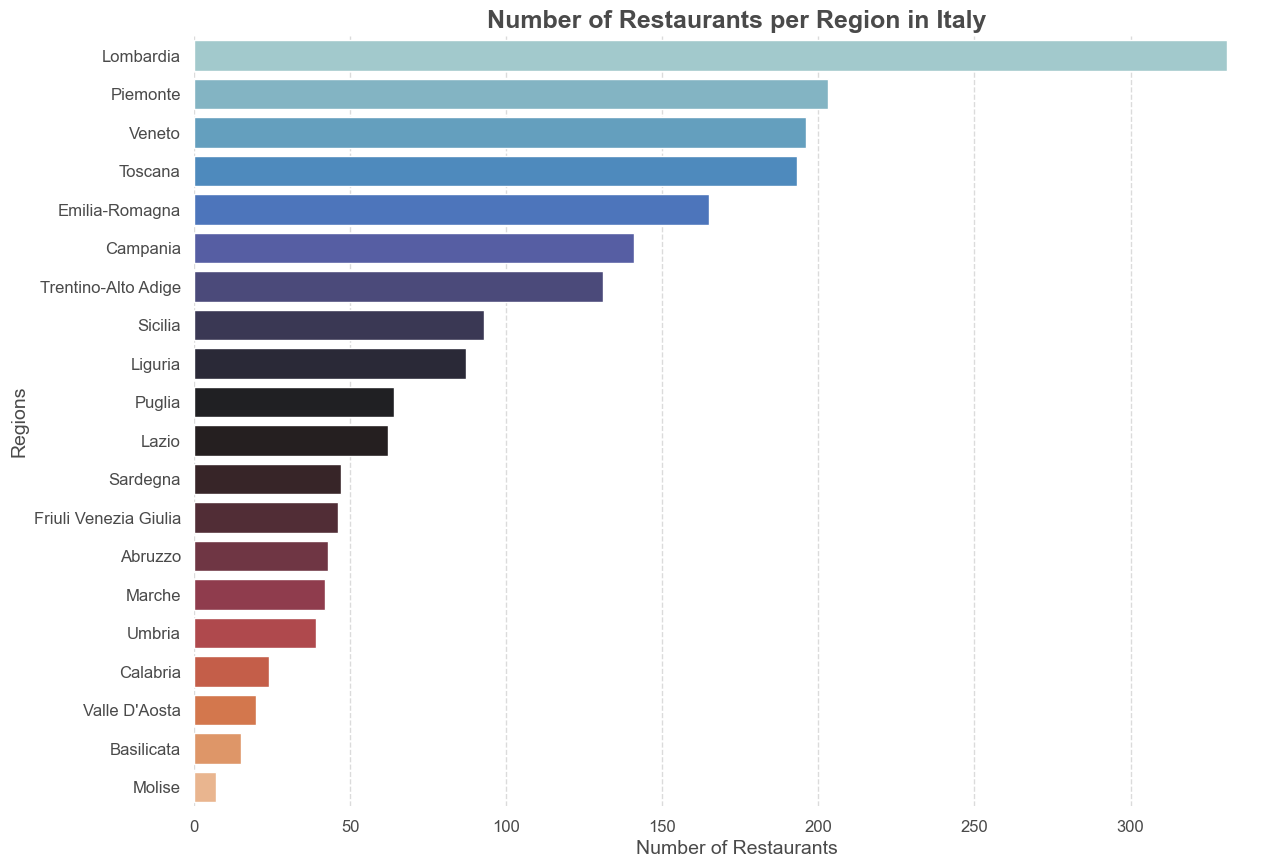

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

region_counts = df['Region'].value_counts()

# Setting the figure, the style and the color palette
sns.set(style="whitegrid")
palette = sns.color_palette("icefire", len(region_counts))
plt.figure(figsize=(14, 10))

# Horizontal bar plot with Seaborn for smoother style
sns.barplot(
    x=region_counts.values,
    y=region_counts.index,
    palette=palette
)

# Adding titles and labels
plt.title('Number of Restaurants per Region in Italy', fontsize=18, fontweight='bold', color='#4a4a4a')
plt.xlabel('Number of Restaurants', fontsize=14, color='#4a4a4a')
plt.ylabel('Regions', fontsize=14, color='#4a4a4a')

# Customization of the grid
plt.xticks(fontsize=12, color='#4a4a4a')
plt.yticks(fontsize=12, color='#4a4a4a')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Removing the top and right spines for a cleaner look
sns.despine(left=True, bottom=True)

# Showing the plot
plt.show()


The region with the highest amount of restaurant is Lombardia. From the plot the regions with most restaurants are located mainly in the north italy. 

****Plotting a plot based on the region and the price ranges that each restaurant in the region has****

In [57]:
# Defining a new variable with the region and the counts for each of the region. 
region_counts_df = region_counts.reset_index()
region_counts_df.columns = ['Region', 'Counts'] 
print(region_counts_df)
# looking at the price range of each restaurant
df['priceRange']
# Transforming the symbol into number, $ = 1, $$ = 2, $$$=3, $$$$=4 which represent the price range for each of the restaurants
df['price'] = df['priceRange'].apply(lambda x: len(x) if x else None)
region_counts_df['price'] = df['price']

                   Region  Counts
0               Lombardia     331
1                Piemonte     203
2                  Veneto     196
3                 Toscana     193
4          Emilia-Romagna     165
5                Campania     141
6     Trentino-Alto Adige     131
7                 Sicilia      93
8                 Liguria      87
9                  Puglia      64
10                  Lazio      62
11               Sardegna      47
12  Friuli Venezia Giulia      46
13                Abruzzo      43
14                 Marche      42
15                 Umbria      39
16               Calabria      24
17          Valle D'Aosta      20
18             Basilicata      15
19                 Molise       7


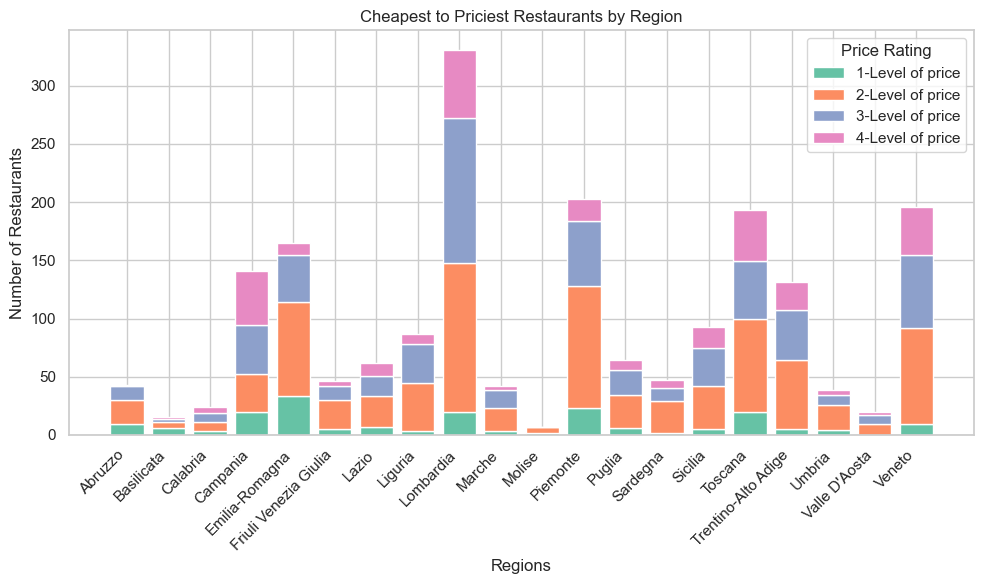

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Grouping by Region and Price to count the number of restaurants
region_counts = df.groupby(['Region', 'price']).size().unstack(fill_value=0)

# Using a seaborn color palette for more appealing colors
colors = sns.color_palette("Set2", n_colors=4) 

# Plotting stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))

price_levels = [1,2, 3, 4, 5] 
for i, price_level in enumerate(price_levels):
    if price_level in region_counts.columns:
        # Bottom layer is cumulative sum of previous layers
        bottom = region_counts[price_levels[:i]].sum(axis=1) if i > 0 else 0
        ax.bar(region_counts.index, region_counts[price_level], bottom=bottom, color=colors[i], label=f"{price_level}-Level of price")
        
# Add labels and title
ax.set_xlabel("Regions")
ax.set_ylabel("Number of Restaurants")
ax.set_title("Cheapest to Priciest Restaurants by Region")
ax.legend(title="Price Rating")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.tight_layout()
plt.show()

The plot is showing the amount of restaurant in each region based on the price ranges, each color corresponds to a specific range. 
Lombardia is the region with the most restaurant and most of them are of price range = 2/3 meaning a bit pricey but not much. 
Most of them are in yellow, showing a medium range

In [59]:
# Defining color based on price range --> plot shows little dots, each represents a restaurant
# with different colors. 
price_color_map = {
    '€': 'green',
    '€€': 'yellow',
    '€€€': 'orange',
    '€€€€': 'red'
}

# map centered around Italy
m = folium.Map(location=[italy_latitude, italy_longitude], zoom_start=6)

# Add markers to the map
for _, row in df.iterrows():
    color = price_color_map.get(row['priceRange'], 'gray')  # Default to gray if price is not in the map
    
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=8,  # Marker size
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=f"<b>{row['restaurantName']}</b><br>Price: {row['price']}<br>Address: {row['address']}, {row['city']}",
    ).add_to(m)

# Add a legend for price ranges
legend_html = '''
     <div style="position: fixed; 
                 bottom: 50px; left: 50px; width: 150px; height: 140px; 
                 border:2px solid grey; background-color:white; z-index:9999; font-size:14px;
                 font-family:Arial, Helvetica, sans-serif; padding: 10px;">
        <b>Price Range</b><br>
        <i style="background-color:green; width:20px; height:20px; display:inline-block; margin-right:5px;"></i> €<br>
        <i style="background-color:yellow; width:20px; height:20px; display:inline-block; margin-right:5px;"></i> €€<br>
        <i style="background-color:orange; width:20px; height:20px; display:inline-block; margin-right:5px;"></i> €€€<br>
        <i style="background-color:red; width:20px; height:20px; display:inline-block; margin-right:5px;"></i> €€€€<br>
     </div>
'''
m.get_root().html.add_child(folium.Element(legend_html))
m.save("restaurant_map.html")
m

#### ****Plot Top-K Restaurants: Use the custom score from Step 3 to select the top-k restaurants for display.****


In [97]:
df.iloc[:,0][df['restaurantName'] == "Osteria Numero 2"]

701    162
Name: index, dtype: int64

In [99]:
top_k_results

[(701, 1.0),
 (73, 0.6204737658737801),
 (1867, 0.5753506830230244),
 (1869, 0.5428305112655476),
 (510, 0.523327633138672)]

In [101]:
score_dict = dict(top_k_results) 
df['score'] = np.nan
for idx, score in score_dict.items():
    df.loc[idx, 'score'] = score
df[df['score']>0]

index              restaurantName                  address  \
73     1063        Remo Villa Cariolato  strada di Bertesina 313   
510    1457                   Aubergine          via Ghislandi 5   
701     162            Osteria Numero 2         via Ghisiolo 2/a   
1867    896                  La Passion       via San Nicolò 5/b   
1869    898  Vert Osteria Contemporanea         Località Bogonza   

                   city  postalCode country priceRange  \
73              Vicenza       36100   Italy         €€   
510         Abano Terme       35031   Italy         €€   
701           Stradella       46051   Italy          €   
1867              Vintl       39030   Italy         €€   
1869   Caprino Veronese       37013   Italy         €€   

                   cuisineType  \
73    Italian, Classic Cuisine   
510   Italian, Classic Cuisine   
701   Italian, Classic Cuisine   
1867  Classic Cuisine, Italian   
1869  Classic Cuisine, Italian   

                                            description  \
73    Long recommended by the Michelin Guide, the hi...   
510   Situated in a town famous for its thermal bath...   
701   A beautiful farmhouse not far from the town, w...   
1867  A small, cosy, completely wood - panelled stub...   
1869  Housed in a rustic building on the green slope...   

                                     facilitiesServices  \
73    ['Air conditioning', 'Car park', 'Garden or pa...   
510         ['Air conditioning', 'Car park', 'Terrace']   
701   ['Air conditioning', 'Car park', 'Garden or pa...   
1867  ['Air conditioning', 'Car park', 'Restaurant o...   
1869  ['Air conditioning', 'Car park', 'Wheelchair a...   

                                       creditCards       phoneNumber  \
73    ['Amex', 'Dinersclub', 'Mastercard', 'Visa']   +39 0444 911007   
510                 ['Amex', 'Mastercard', 'Visa']  +39 049 866 9910   
701                 ['Amex', 'Mastercard', 'Visa']    +39 0376 45088   
1867                ['Amex', 'Mastercard', 'Visa']   +39 0472 868595   
1869                ['Amex', 'Mastercard', 'Visa']  +39 327 770 9794   

                                  website  \
73      https://www.removillacariolato.it   
510   https://www.ristoranteaubergine.it/   
701        https://www.osterianumero2.it/   
1867         https://www.lapassion.it/it/   
1869              https://vertosteria.it/   

                                   coordinates   latitude  longitude  \
73                    (45.5588446, 11.5923482)  45.558845  11.592348   
510     (45.35173986023884, 11.77538670450566)  45.351740  11.775387   
701   (45.179933500000004, 10.872908631705698)  45.179934  10.872909   
1867           (46.8758184, 11.72086444217766)  46.875818  11.720864   
1869                  (45.6055315, 10.8057343)  45.605531  10.805734   

                   Region  price     score  
73                 Veneto      2  0.620474  
510                Veneto      2  0.523328  
701             Lombardia      1  1.000000  
1867  Trentino-Alto Adige      2  0.575351  
1869               Veneto      2  0.542831

In [104]:
df[df['score'] > 0]

index              restaurantName                  address  \
73     1063        Remo Villa Cariolato  strada di Bertesina 313   
510    1457                   Aubergine          via Ghislandi 5   
701     162            Osteria Numero 2         via Ghisiolo 2/a   
1867    896                  La Passion       via San Nicolò 5/b   
1869    898  Vert Osteria Contemporanea         Località Bogonza   

                   city  postalCode country priceRange  \
73              Vicenza       36100   Italy         €€   
510         Abano Terme       35031   Italy         €€   
701           Stradella       46051   Italy          €   
1867              Vintl       39030   Italy         €€   
1869   Caprino Veronese       37013   Italy         €€   

                   cuisineType  \
73    Italian, Classic Cuisine   
510   Italian, Classic Cuisine   
701   Italian, Classic Cuisine   
1867  Classic Cuisine, Italian   
1869  Classic Cuisine, Italian   

                                            description  \
73    Long recommended by the Michelin Guide, the hi...   
510   Situated in a town famous for its thermal bath...   
701   A beautiful farmhouse not far from the town, w...   
1867  A small, cosy, completely wood - panelled stub...   
1869  Housed in a rustic building on the green slope...   

                                     facilitiesServices  \
73    ['Air conditioning', 'Car park', 'Garden or pa...   
510         ['Air conditioning', 'Car park', 'Terrace']   
701   ['Air conditioning', 'Car park', 'Garden or pa...   
1867  ['Air conditioning', 'Car park', 'Restaurant o...   
1869  ['Air conditioning', 'Car park', 'Wheelchair a...   

                                       creditCards       phoneNumber  \
73    ['Amex', 'Dinersclub', 'Mastercard', 'Visa']   +39 0444 911007   
510                 ['Amex', 'Mastercard', 'Visa']  +39 049 866 9910   
701                 ['Amex', 'Mastercard', 'Visa']    +39 0376 45088   
1867                ['Amex', 'Mastercard', 'Visa']   +39 0472 868595   
1869                ['Amex', 'Mastercard', 'Visa']  +39 327 770 9794   

                                  website  \
73      https://www.removillacariolato.it   
510   https://www.ristoranteaubergine.it/   
701        https://www.osterianumero2.it/   
1867         https://www.lapassion.it/it/   
1869              https://vertosteria.it/   

                                   coordinates   latitude  longitude  \
73                    (45.5588446, 11.5923482)  45.558845  11.592348   
510     (45.35173986023884, 11.77538670450566)  45.351740  11.775387   
701   (45.179933500000004, 10.872908631705698)  45.179934  10.872909   
1867           (46.8758184, 11.72086444217766)  46.875818  11.720864   
1869                  (45.6055315, 10.8057343)  45.605531  10.805734   

                   Region  price     score  
73                 Veneto      2  0.620474  
510                Veneto      2  0.523328  
701             Lombardia      1  1.000000  
1867  Trentino-Alto Adige      2  0.575351  
1869               Veneto      2  0.542831

In [107]:
import folium
import pandas as pd

# Define the top-K parameter
K = 5  # Select the top 5 restaurants
top_restaurants = df[df['score'] > 0]


# Initialize a folium map centered on Italy
map_center = [italy_latitude, italy_longitude]  # Rome's coordinates as a central point
m = folium.Map(location=map_center, zoom_start=6)

# Function to choose color based on price range
def get_color(price_range):
    colors = {"€": "green", "€€": "blue", "€€€": "orange", "€€€€": "red"}
    return colors.get(price_range, "gray")

# Add all restaurants to the map
#for _, row in df.iterrows():
    #folium.Marker(
       # location=[row["latitude"], row["longitude"]],
      #  popup=f"{row['city']} ({row['priceRange']}): Score {row['score']}",
      #  icon=folium.Icon(color=get_color(row["priceRange"]))
  #  ).add_to(m)

# Highlight top-K restaurants with larger markers and a unique icon
for _, row in top_restaurants.iterrows():
    folium.Marker(
        location=[row["latitude"], row["longitude"]],
        popup=f"{row['restaurantName']} {row['city']} ({row['priceRange']}): Score {row['score']}",
        icon=folium.Icon(color="purple", icon="star")
    ).add_to(m)

# Display the map
m.save("italy_restaurants_map.html")
m

## Question 5 - BONUS: Advanced Search Engine

__Note__: This is an optional step to enhance the search engine with advanced filtering and querying options.

To create an advanced restaurant search, provide users with the following options:

1. **Specify Search Criteria**: Users can specify search terms for the following features (any or all of them):
   - `restaurantName`
   - `city`
   - `cuisineType`

2. **Price Range Filter**: Allow users to set a price range (e.g., between `€` and `€€€`) to filter the results by affordability.

3. **Region Filter**: Enable users to specify a list of Italian regions to limit the search to restaurants within those regions.

4. **Accepted Credit Cards**: Provide an option to filter by accepted credit card types. Users can specify one or more preferred card types (e.g., Visa, MasterCard, Amex).

5. **Services and Facilities**: Allow users to filter based on specific services and facilities provided by the restaurant. For example, users may look for amenities like Wi-Fi, Terrace, Air Conditioning, or Parking.

### Implementation Tips:

- **Inverted Index for Specific Fields**: Build additional inverted indexes for the fields `restaurantName`, `city`, and `cuisineType`. Aggregate the similarity scores from these fields to rank results logically.
- **Filter Application**: All other filters should be applied as criteria, meaning the returned restaurants must meet all specified filters.

### Output Format:
The output should include:
- `restaurantName`
- `address`
- `cuisineType`
- `priceRange`
- `website`



In [ ]:
def inverted_index_init(data):
    index = defaultdict(set)

    # Tokenize and index fields for search
    for i, row in data.iterrows():
        for field in ['restaurantName', 'city', 'cuisineType']:
            if pd.notna(row[field]):
                for word in row[field].lower().split():
                    index[word].add(i)
    return index

# Build the inverted index once
def advanced_restaurants_search(data, name=None, city=None, cuisine_type=None, min_price=None, max_price=None, regions=None, credit_cards=None, facilities=None):
    # Get matching indices for name, city, and cuisine type
    data_aux = data.copy()
    inverted_index = inverted_index_init(data_aux)
    matching_indices = set(range(len(data_aux)))

    # Search by name using inverted index
    if name:
        name_terms = name.lower().split()
        name_matches = set()
        for term in name_terms:
            name_matches.update(inverted_index.get(term, set()))
        matching_indices &= name_matches

    # Search by city using inverted index
    if city:
        city_terms = city.lower().split()
        city_matches = set()
        for term in city_terms:
            city_matches.update(inverted_index.get(term, set()))
        matching_indices &= city_matches

    # Search by cuisine type using inverted index
    if cuisine_type:
        cuisine_terms = cuisine_type.lower().split()
        cuisine_matches = set()
        for term in cuisine_terms:
            cuisine_matches.update(inverted_index.get(term, set()))
        matching_indices &= cuisine_matches

    # Filter by price range
    if min_price or max_price:
        price_values = {'€': 1, '€€': 2, '€€€': 3, '€€€€': 4}
        min_price_value = price_values.get(min_price, 1)
        max_price_value = price_values.get(max_price, 4)
        matching_indices &= set(data_aux.index[data_aux['priceRange'].apply(lambda x: price_values.get(x, 0) >= min_price_value and price_values.get(x, 0) <= max_price_value)])

    if regions:
        # Define postal code ranges and corresponding regions
        postal_code_ranges = [
            (10000, 12999, "Piemonte"),
            (13000, 13999, "Valle d'Aosta"),
            (15000, 19999, "Piemonte"),
            (20000, 20999, "Lombardia"),
            (21000, 23999, "Lombardia"),
            (25000, 28999, "Lombardia"),
            (30000, 34999, "Veneto"),
            (36000, 36999, "Veneto"),
            (37000, 39999, "Veneto"),
            (40000, 47999, "Emilia-Romagna"),
            (38000, 38999, "Trentino-Alto Adige"),
            (50000, 59100, "Toscana"),
            (60000, 63999, "Marche"),
            (64000, 64999, "Abruzzo"),
            (66000, 66999, "Abruzzo"),
            (67000, 67999, "Molise"),
            (70000, 71999, "Puglia"),
            (75000, 75999, "Basilicata"),
            (80000, 84999, "Campania"),
            (85000, 86999, "Basilicata"),
            (87000, 89999, "Calabria"),
            (90000, 91999, "Sicilia"),
            (95000, 98199, "Sicilia"),
            (7000, 9199, "Sardegna"),
            (100, 199, "Lazio"),
            (1000, 1999, "Lazio"),
            (3000, 3999, "Lazio")
        ]

        postal_code_ranges.sort()
        start_points = [start for start, end, region in postal_code_ranges]

        # Binary search to find the region for a given postal code
        def region_from_postal_code(postal_code):
            from bisect import bisect_left

            postal_code = int(postal_code)
            idx = bisect_left(start_points, postal_code)
            start, end, region = postal_code_ranges[idx-1]
            if start <= postal_code <= end:
               return region
            return "Unknown Region"


        # Add the region column to data_aux
        data_aux['region'] = data_aux['postalCode'].apply(region_from_postal_code)

        # Apply region filter
        region_list = regions.split(",")
        matching_indices &= set(data_aux.index[data_aux['region'].isin(region_list)])

    # Filter by credit cards
    if credit_cards:
        matching_indices &= set(data_aux.index[data_aux['creditCards'].apply(lambda x: any(card in x for card in credit_cards))])

    # Filter by facilities
    if facilities:
        matching_indices &= set(data_aux.index[data_aux['facilitiesServices'].apply(lambda x: all(facility in x for facility in facilities))])

    # Retrieve the final filtered data_aux
    result = data_aux.loc[list(matching_indices), ['restaurantName', 'address', 'city','cuisineType', 'priceRange', 'website']]

    return result

print("Advanced search Test:")
advanced_search_result1 = advanced_restaurants_search(data, city="Modena", regions="Emilia-Romagna", min_price="€€", max_price="€€€")
headers = advanced_search_result1.columns.tolist()
rows = advanced_search_result1.values.tolist()
print(tabulate(rows, headers=headers, tablefmt='grid'))

print("Advanced search Test:")
advanced_search_result2 = advanced_restaurants_search(data, cuisine_type="Italian", min_price="€€", max_price="€€€")
headers = advanced_search_result2.columns.tolist()
rows = advanced_search_result2.values.tolist()
print(tabulate(rows, headers=headers, tablefmt='grid'))

| Restaurant Name     | Address               | City                  | Cuisine Type               | Price Range | Website                          |
|---------------------|-----------------------|-----------------------|---------------------------|-------------|----------------------------------|
| Franceschetta 58    | strada Vignolese 58  | Modena                | Emilian, Regional Cuisine | €€          | [Link](http://www.franceschetta.it) |
| Antica Moka         | Via Emilia Est 1496  | Modena                | Modern Cuisine            | €€€         | [Link](https://www.anticamoka.it/) |
| Locanda del Feudo   | via Trasversale 2    | Castelvetro di Modena | Traditional Cuisine       | €€          | [Link](https://locandadelfeudo.it/it/) |
| Hosteria Giusti     | via Farini 75        | Modena                | Emilian                   | €€€         | [Link](http://www.hosteriagiusti.it) |
| L'Erba del Re       | via Castelmaraldo 45 | Modena                | Creative                  | €€€         | [Link](https://www.lerbadelre.it/) |

Exaple output :


| Restaurant Name                        | Address                                          | City                        | Cuisine Type                                         | Price Range | Website                                                                                |
|----------------------------------------|--------------------------------------------------|-----------------------------|-----------------------------------------------------|-------------|----------------------------------------------------------------------------------------|
| Le Petit Bellevue                     | rue Grand Paradis 22                             | Cogne                       | Italian Contemporary, Cuisine from the Aosta Valley | €€€         | [Link](https://www.hotelbellevue.it/it/ristoranti/view/le-petit-bellevue)              |
| Villa Lattanzi                        | contrada Cugnolo 19                              | Torre di Palme              | Italian Contemporary, Modern Cuisine                | €€€         | [Link](https://www.villalattanzi.it/)                                                  |
| Frosch Restaurant                     | via Santi Pietro e Paolo 1                       | Varena                      | Contemporary, Italian Contemporary                  | €€€         | [Link](https://www.frosch-restaurant.com/)                                             |
| Antica Osteria del Ponte              | piazza Gaetano Negri 9                           | Cassinetta di Lugagnano     | Italian Contemporary                                | €€€         | [Link](http://www.anticaosteriadelponte.it)                                            |
| Il Poggio                             | via Panoramica 4                                 | Poggiridenti                | Country cooking, Italian Contemporary               | €€          | [Link](http://www.ilpoggioristorante.it)                                               |
| Casa Perrotta Restaurant              | via Cinque Giornate 72                           | Cernobbio                   | Italian Contemporary                                | €€€         | [Link](https://www.casaperrottarestaurant.it)                                          |
| Ca' Del Moro                          | località Erbin 31                                | Grezzana                    | Italian Contemporary, Mediterranean Cuisine         | €€€         | [Link](https://www.cadelmoro.wine/it)                                                 |




# ALGORITHM QUESTION


#### ***1.Write the pseudocode for an algorithm that solves this problem.***

> Input n #number of packages
Initializing packages as an empty list to be filled later with the coordinates of each package

##### Getting the coordinates of the packages and appending them in the list:
> For coordinates from 1 to n:
    Input x, y  # Coordinates of the package
    Append (x, y) to packages

##### Sorting the packages by x first, then by y:
> Sort packages by x and y

##### Assigning variables: 
> Assigning the starting position as (0, 0), where we shouldnt have any gift
Initializing path as an empty string to then being filled with the letters R (right) and U (up)
Initializing result variable as "YES", this variable is meant to assume that we collected all the needed packages, so in the cases  

##### Checking and collecting each package with a for loop:
> For each (xi, yi) in packages:
    If xi < start.x OR yi < start.y:
        result = "NO"  # If moving backward we should stop and the result changes. 
        Breaking the loop to stop the cheking
    instead in the case in which we can actually move to right and up we keep going with the loop
    `If xi > start.x:
        Add 'R' (xi - start.x) # R is multiplied for the difference between the xi and the starting x, this shows how many steps to the right we are doing.
    
    If yi > start.y:
        Add 'U' (yi - start.y)  # U is multiplied for the difference between the yi and the starting y, this shows how many steps to the right we are doing.
    
    Update start to (xi, yi) ` # Updating the position so to continue with the loop

##### Checking the Result:
> If result is "NO":
    Print "NO"
Else:
    Print "YES"
    Print path # Printing the entire path 


To prove that the algorithm is correct, we make some adjustments and give as input the following information: \
Input: \
3 \
5 \
1 3 \
1 2 \
3 3 \
5 5 \
4 3 \
2 \
1 0 \
0 1 \
1 \
4 3 


Which would give as an output: \
YES \
RUUURRRRUU \
NO \
YES \
RRRRUUU 

#### ***2. Proving the algorithm is correct***

In [1]:
n = int(input()) # number of test cases
final = []
for _ in range(n): 
    packages = [] # we put the packages list in the for loop, so to reset the list every loop 
    m = int(input())
    for _ in range(m): # number of packages
        x, y = map(int, input().split()) # coordinates of the packages
        packages.append((x,y)) # list of all the coordinates of the packages list[[(0,1),(0,9)]]
    
    # ordering the packages 
    packages.sort()

    start = (0,0)
    path = ''
    result = 'YES' # initially is yes
    for xi,yi in packages: 
        if xi < int(start[0]) or yi < int(start[1]): # if one package cannot be found we need to stop the calculation
            result = 'NO' 
            break # we stop the checking because we cannot reach all the packages 
        if xi > start[0]: # if xi greater than the x of the first package
            path += 'R' * (xi - start[0]) # since xi is greater than the starting point x,0, we more to the right and we add R to path
            # but we multiply it for how many times we move to the right 
        if yi > start[1]: 
            path += 'U' * (yi - start[1]) # same logic as before
            
        start = (xi,yi) # updating the starting point so to move on 
        
    if result == 'YES': # to check if we reached stopped or not 
        final.append("YES")
        final.append(path)
    else: 
        final.append("NO")

for x in final:
    print(x)

YES
RUUURRRRUU
NO
YES
RRRRUUU


#### ***3. Compute the time complexity of your algorithm in Big O notation. Break down the steps involved in the algorithm, and explain which parts contribute most to the overall time complexity.***

The big O Notation is a way to describe how the time and space needed by an algorithm grows as the size of the input increases.
The total notation of the function is \(O(`nlogn`) \)

## **ANALYSIS**
1. **Input**: At the beginning we give as input the values `n` and `m`, which have each a complexity time of `n`: \( O(`1`) \), `m`: \( O(`1`) \)
2. **First for loops**: The first loop iterates `n` times, so it actually present a time complexity of `n`: \( O(`n`) \). 
3. **Second for loop**: The second loop iterates `m` times, so it present a time complexity of `m`: \( O(`n`) \).
4. **Sorting**: We then follow with the sorting of the list that presents all the coordinates. In the best case scenarios, the time complexity is \(O(`n`) \), but in the worst scenarios the complexity is \(O(`n*mlogn * m`) \). We add the m because we also need to consider the second loop that iterates m times.

For the second part, 
1. **Assigning**: we have the assigning of several variables which have a complexity of  `n`: \( O(`1`) \) because it is an operation that take the same amount of time all the times. 
2. **For loop**: The following for loop checks each package after sorting, determining a complexity of \( O(`m`) \).
3. **If Statements**: The 4 if statements perform a constant-time check regardless of the size of the input, indeed the if statements evaluates a condition thus it present a complexity of `n`: \( O(`1`) \) . 
4. **Final for loop**: the last for loop iterates over the list of paths, collected throughout the execution of the code. Considering that n represent the number of test cases. The total time complexity is  \( O(`n`) \)
### **CONCLUSION**
To calculate the total time complexity of the entire code, we need to combine the complexities of each part while considering the dominant terms.
* For the first part: In the worst case, the dominant term is \( O(`n*mlogn*m`) \) 
* For the second part: the variable and if assignments are not considered since they present a complexity of n(1), so the overall complexity of the second part is \( O(`m`) \) . 

#### Thus the total complexity of the code is \( O(`n*mlogn*m`) \) .

#### ***4.Ask an LLM tool (such as ChatGPT, Claude AI, Gemini, Perplexity, etc.) to evaluate the time complexity of your code using Big O notation. Is the assessment accurate? If it differs from your previous analysis, which would be correct? Please explain your reasoning.***

For the AI the code's complexity is the following:

1. **Reading the Input**:
   - Reading the number of test cases `n`: \( O(1) \)
   - Reading the number of packages `m` for each test case: \( O(n) \)
   - Reading the coordinates `x, y` for each package: \( O(n \times m) \)

2. **Sorting the Packages**:
   - Sorting the `packages` list: \( O(n \times m \log (n \times m)) \)

3. **Calculating the Path**:
   - Iterating through the sorted `packages` list: \( O(n \times m) \)
   - Performing constant-time operations (comparisons, string concatenation) within the loop: \( O(n \times m) \)

4. **Printing the Result**:
   - Iterating through the `final` list: \( O(n) \)
   - Printing each element: \( O(n) \)

Combining the complexities, the overall time complexity of the code is:

$$ O(1) + O(n) + O(n \times m) + O(n \times m \log (n \times m)) + O(n \times m) + O(n) + O(n) = O(n \times m \log (n \times m)) $$

The dominant term in the time complexity is \( O(n \times m \log (n \times m)) \), which is the complexity of sorting the `packages` list.

### ****Our time complexity consideration is the same as the AI's****

#### ***5.Assume now that the robot can also move towards the left or downwards, and consider the greedy approach: from the current location go to the closest package. Notice that now we can always collect all packages. Prove that the greedy algorithm is optimal (i.e., it minimizes the total distance traveled), or provide a counterexample showing that it is not.****


The greedy approach is an approach for solving problems by selecting the best option available. To prove that, we present an example.

---

### Proving That the Greedy Approach Always Yields the Optimal Solution

**Example of a scenario where the greedy algorithm is not suitable**:  
Consider a robot starting at the origin (0, 0) with three packages located at the following coordinates:

- Package A: (1, 3)  
- Package B: (4, 1)  
- Package C: (2, 2)

#### Assumptions:
The robot can move in any direction (up, down, right, and left).

---

### Greedy Algorithm Steps:

1. **Initial Position**: (0, 0)

2. **Distances to Packages**:
   - **Distance to Package A**:  
     \begin{equation} \tag{1}
     d_A = \sqrt{(1-0)^2 + (3-0)^2} = \sqrt{1 + 9} = \sqrt{10} \approx 3.16
     \end{equation}
   - **Distance to Package B**:  
     \begin{equation} \tag{2}
     d_B = \sqrt{(4-0)^2 + (1-0)^2} = \sqrt{16 + 1} = \sqrt{17} \approx 4.12
     \end{equation}
   - **Distance to Package C**:  
     \begin{equation} \tag{3}
     d_C = \sqrt{(2-0)^2 + (2-0)^2} = \sqrt{4 + 4} = \sqrt{8} \approx 2.83
     \end{equation}

   **Step 1 Decision**: The robot selects Package C as it is the closest.

3. **Next Steps**:  
   Recalculate distances from the robot's new position (2, 2).  
   - **Distance to Package A**:  
     \begin{equation} \tag{4}
     d_{C \to A} = \sqrt{(1-2)^2 + (3-2)^2} = \sqrt{1 + 1} = \sqrt{2} \approx 1.41
     \end{equation}
   - **Distance to Package B**:  
     \begin{equation} \tag{5}
     d_{C \to B} = \sqrt{(4-2)^2 + (1-2)^2} = \sqrt{4 + 1} = \sqrt{5} \approx 2.24
     \end{equation}

   **Step 2 Decision**: The robot selects Package A as it is now the closest.

---

### **Total Distance with Greedy Approach**:
- Move to Package C:  
  \begin{equation} \tag{6}
  d_C = \sqrt{8}
  \end{equation}
- Move to Package A:  
  \begin{equation} \tag{7}
  d_{C \to A} = \sqrt{2}
  \end{equation}

**Total Distance (Greedy)**:  
\begin{equation} \tag{8}
d_C + d_{C \to A} = \sqrt{8} + \sqrt{2} \approx 2.83 + 1.41 \approx 4.24
\end{equation}

---

### The Optimal Path:

Instead, if the robot chooses Package A as the first package:

1. **Move to Package A (1, 3)**:  
   \begin{equation} \tag{9}
   d_A = \sqrt{10} \approx 3.16
   \end{equation}

2. **Move from Package A (1, 3) to Package B (4, 1)**:  
   \begin{equation} \tag{10}
   d_{A \to B} = \sqrt{(4-1)^2 + (1-3)^2} = \sqrt{9 + 4} = \sqrt{13} \approx 3.61
   \end{equation}

---

### **Total Distance with Optimal Path**:
- Move to Package A:  
  \begin{equation} \tag{11}
  d_A = \sqrt{10}
  \end{equation}
- Move to Package B:  
  \begin{equation} \tag{12}
  d_{A \to B} = \sqrt{13}
  \end{equation}

**Total Distance (Optimal)**:  
\begin{equation} \tag{13}
\sqrt{10} + \sqrt{13} \approx 3.16 + 3.61 \approx 6.77
\end{equation}

---

### Conclusion:
Thus, the greedy algorithm does yield the optimal path, as it leads to a total distance of approximately **4.24**, while the "optimal path" yields a total distance of approximately **6.77**.

#### The greedy algorithm has proven to yield the optimal path in some cases, but not always.
